Nhat Nguyen

Question 2

1)

a. The state space is a grid world with 25 columns and 25 rows, where each state is defined by its position. This means that each state has the form x = {1, 2, 3,...,25} and y = {1, 2, 3,...,25}.

b. The possible actions are up, down, left, right, and stay

c. The absorbing state is E = (1, 1)

d. The transition function is deterministic transition. The agents cannot move more than one box and cannot move outside the grid world, so some boxes will have limited action it can take.

e. Reward: -1 for transitioning states, 0 for the goal state

f. Discount factor: Let assume (γ) = 0.99 for this inifnite time horizon to ensure less variance and irrelevant information.


2) Policy Iteration and Value Iteration

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

class ReinforcementLearning:
  def __init__(self, block, grid=25):
    self.grid = grid
    # Actions: up, down, left, right, stay
    self.action = [0, 1, 2, 3, 4]
    self.goal = (0, 0)
    self.block_cells = self.goal_blocked_prevention(block)
    self.gamma = 0.9
    self.thet = 0.01
    self.rewards = self.set_reward()

  #Making sure that the goal stay is not blocked
  def goal_blocked_prevention(self, block):
    if self.goal in block:
      sys.exit("Goal state cannot be blocked. Please try again.")
    else:
      return block

  # set_reward for empty, blocked, and goal cells
  def set_reward(self):
    # Default reward
    rewards = -1 * np.ones((self.grid, self.grid))
    # Reward at goal should be 0 to distinguish
    rewards[self.goal] = 0
    # Set rewards for blocked cells
    for cell in self.block_cells:
        x, y = cell
        rewards[x, y] = -100
    return rewards

  #init_policy - a. Start with an initial random policy
  def init_policy(self):
    #Assign a uniform probability for each action
    p = 1 / 5 * np.ones((self.grid, self.grid, 5))
    goal_x, goal_y = self.goal
    #Except for the goal state. The agent should stay at this point
    p[goal_x, goal_y] = np.array([0, 0, 0, 0, 1])
    return p

  #define the next action that the agent can take to traverse the cell
  def next_action(self, state, action):
    x, y = state

    if action == 0 and x > 0 and (x-1, y) not in self.block_cells:  # Up
        return (x-1, y)
    elif action == 1 and x < self.grid - 1 and (x+1, y) not in self.block_cells:  # Down
        return (x+1, y)
    elif action == 2 and y > 0 and (x, y-1) not in self.block_cells:  # Left
        return (x, y-1)
    elif action == 3 and y < self.grid - 1 and (x, y+1) not in self.block_cells:  # Right
        return (x, y+1)
    else:
        # Stay or invalid move
        return state


  #b. Implement policy evaluation to calculate the value function for the policy.
  def policy_evaluation(self, random_policy, value_function):
    converge = False

    while not converge:
      delta = 0
      temp = np.copy(value_function)
      for x in range(self.grid):
        for y in range(self.grid):
          if (x, y) == self.goal:
            continue
          e = 0
          for a in self.action:
            next_x, next_y = self.next_action((x, y), a)

            #Bellman Expectation
            e += random_policy[x, y, a] * (self.rewards[next_x, next_y] + self.gamma * temp[next_x, next_y])
          value_function[x, y] = e
          delta = max(delta, abs(temp[x, y] - value_function[x, y]))

      if delta < self.thet:
        converge = True

    return value_function

  #c. Implement policy improvement to update the policy based on the value function.
  def policy_improvement(self, random_policy, value_function):
    stable = True
    new_policy = np.zeros_like(random_policy)

    for x in range(self.grid):
      for y in range(self.grid):
        old_act = np.argmax(random_policy[x, y])

        actions_val = []
        for a in range(len(self.action)):
          next_x, next_y = self.next_action((x, y), a)
          action_value = self.rewards[next_x, next_y] + self.gamma * value_function[next_x, next_y]
          actions_val.append(action_value)

        best_act = np.argmax(actions_val)
        #Greedy computation - force the agent to choose the best act
        new_policy[x, y, best_act] = 1.0

        if best_act != old_act:
          stable = False

    random_policy = new_policy
    return stable, random_policy

  #d. Repeat policy evaluation and improvement until the policy converges.
  def policy_iteration(self):
    iteration = 0
    stable = False
    value_function = np.zeros((self.grid, self.grid))
    random_policy = self.init_policy()

    while not stable:
      value_function = self.policy_evaluation(random_policy, value_function)
      stable, random_policy = self.policy_improvement(random_policy, value_function)
      iteration += 1

    optimal_function = value_function
    optimal_policy = random_policy
    return optimal_function, optimal_policy

  # intermediate_policy_iteration return an intermediate policy found using
  def intermediate_policy_iteration(self, max_iteration):
    inter_function = np.zeros((self.grid, self.grid))
    inter_policy = self.init_policy()

    while max_iteration != 0:
      inter_function = self.policy_evaluation(inter_policy, inter_function)
      stable, inter_policy = self.policy_improvement(inter_policy, inter_function)
      max_iteration -= 1

    return inter_function, inter_policy

  #Value iteration
  def value_iteration(self):
    #Get optimal value function
    value_function = np.zeros((self.grid, self.grid))
    converge = False
    while not converge:
      delta = 0
      temp = np.copy(value_function)
      for x in range(self.grid):
        for y in range(self.grid):
          if (x, y) == self.goal:
            continue
          actions_val = []
          for a in self.action:
            next_x, next_y = self.next_action((x, y), a)
            val = self.rewards[next_x, next_y] + self.gamma * value_function[next_x, next_y]
            actions_val.append(val)

          value_function[x, y] = max(actions_val)
          delta = max(delta, abs(temp[x, y] - value_function[x, y]))

      if delta < self.thet:
        converge = True
    #Get optimal policy
    iteration = 0
    policy = self.init_policy()
    for x in range(self.grid):
      for y in range(self.grid):
        if (x, y) == self.goal or (x, y) in self.block_cells:
          continue
        best_act = []
        for a in range(len(self.action)):
          next_x, next_y = self.next_action((x, y), a)
          action_value = self.rewards[next_x, next_y] + self.gamma * value_function[next_x, next_y]
          best_act.append(action_value)

        best_act = np.argmax(best_act)
        policy[x, y, best_act] = 1.0
        iteration += 1

    return value_function, policy, iteration

  #Plotting
  def plot_function(self, val_function):
    plt.figure(figsize=(10,10))
    plt.imshow(val_function, cmap= 'autumn', interpolation = 'nearest')
    plt.colorbar(label='Value')
    plt.title('Function Heatmap')
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.show()

  def plot_policy(self, policy):
    # Define a simple mapping from action index to arrows (left, right, up, down, stay)
    action_map = {
      0: '^',  # up
      1: 'v',  # down
      2: '<',  # left
      3: '>',  # right
      4: 'o'   # goal (stay)
    }
    grid_size = policy.shape[0]
    policy_grid = np.zeros((grid_size, grid_size), dtype=str)

    # Fill the policy_grid with corresponding symbols
    for x in range(grid_size):
      for y in range(grid_size):
        best_action = np.argmax(policy[x, y])
        policy_grid[x, y] = action_map[best_action]

        if (x, y) == (0, 0):
          policy_grid[x, y] = action_map[4]
        elif (x, y) in self.block_cells:
          policy_grid[x, y] = 'x'

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(np.zeros_like(policy_grid, dtype=float), cmap='Greys')  # Create a grey background

    # Add text annotations for each cell in the grid
    for x in range(grid_size):
      for y in range(grid_size):
        ax.text(y, x, policy_grid[x, y], ha='center', va='center', color='blue', fontsize=14)

    ax.set_title('Policy Grid Map')
    plt.xlabel('State Y')
    plt.ylabel('State X')
    plt.xticks(ticks=np.arange(grid_size), labels=np.arange(grid_size))
    plt.yticks(ticks=np.arange(grid_size), labels=np.arange(grid_size))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.show()

  #traversal - return the number of steps taken to reach the goal
  def traversal(self, start, policy):
    steps = 0
    reach_goal = False
    x, y = start
    while not reach_goal:
      action = np.argmax(policy[x, y])
      x, y = self.move(action, x, y)
      steps += 1
      if (x, y) == self.goal:
        reach_goal = True
      elif steps == 625:
        return steps

    return steps

  #move - helper function toperform action according to the policy and retrieve the new agent's position
  def move(self, action, x, y):
    new_x, new_y = x, y

    match action:
      case 0:
        new_x = max(0, x-1)

      case 1:
        new_x = min(self.grid - 1, x + 1)

      case 2:
        new_y = max(0, y - 1)

      case 3:
        new_y = min(self.grid - 1, y + 1)

      case 4:
        return new_x, new_y

    if (new_x, new_y) in self.block_cells:
        return x, y

    return new_x, new_y


3) Visualization

Explanation:

Below is the visualization of both optimal policy and optimal value function that is produced by both policy iteration and value iteration.

Value Function Heatmap (Optimal Value Function)

The heat map is configured so that the color range from yellow to red, with yellow being closest to 0, indicating the goal, to red which is -8. In the heatmap, the cells in the area closest to the goal are gradually turning from red to yellow, indicating that the closer a cell is to the goal, the higher the value and the higher the level of "goodness" it is, as opposed to cells further away from the goal are being more red and less good in terms of value

Policy Grid Map (Optimal Policy Function)

This map models the 25x25 grid environment and provides the action that the action that an agent can take for each cell at each state. The arrows that determine the agent's action is as followed:

'^' means the agent moves up

'V' means the agent moves down

'<' means the agent moves left

'>' means the agent moves right

'o' means the agent is at goal state so stay

'x' means this is an obstacle and the agent must avoid

For example, at cell (0, 6), the agent saw an obstacle 'x' on its left side. Therefore it chooses the action 'V', which is moving down to avoid the obstacle. Then at (1, 6), the agent continue to go left toward the goal state.

Analysis of the result:

Here, both policy iteration and value iteration produce the same optimal value function and optimal policy function, which is completely expected as these are optimal, which means that the agent can reach the goal state in the shortest amount of steps possible.

Optimal value function for policy iteration


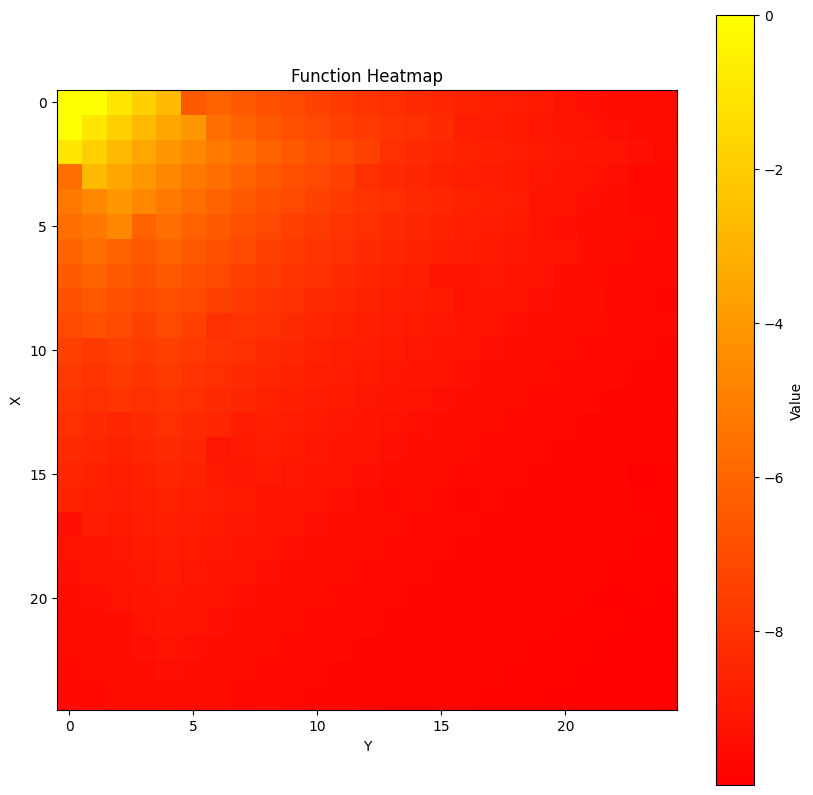

Optimal policy function for policy iteration


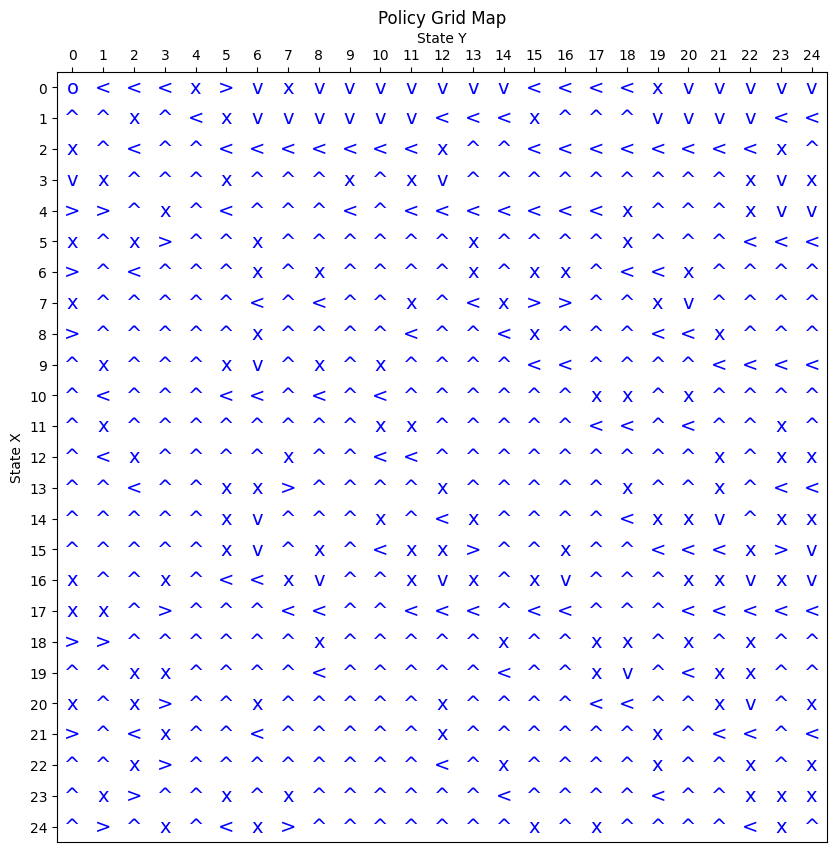

Optimal value function for value iteration


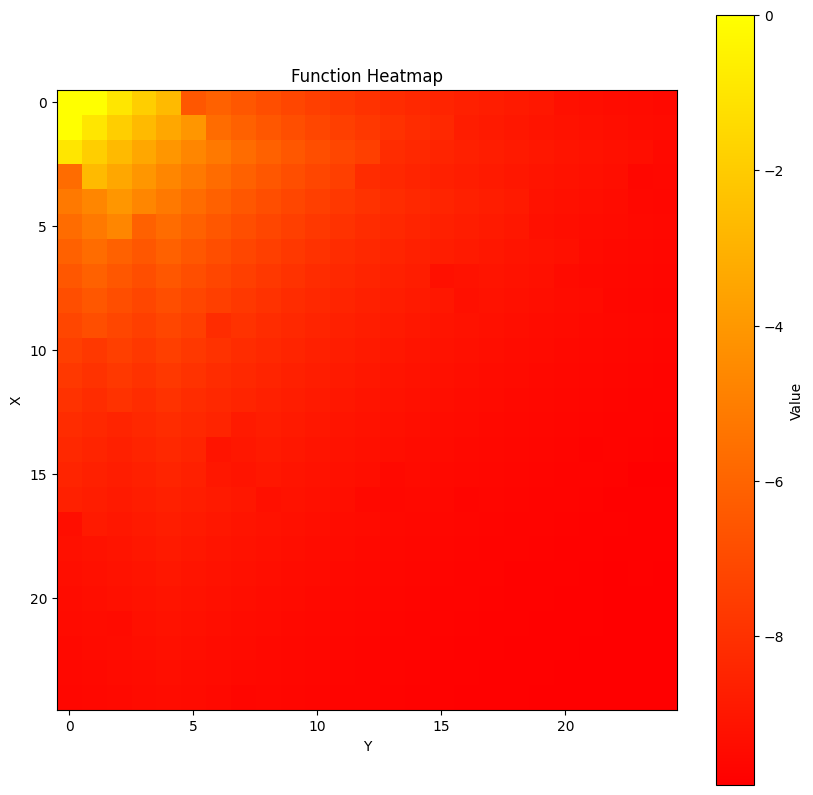

Optimal policy function for value_iteration


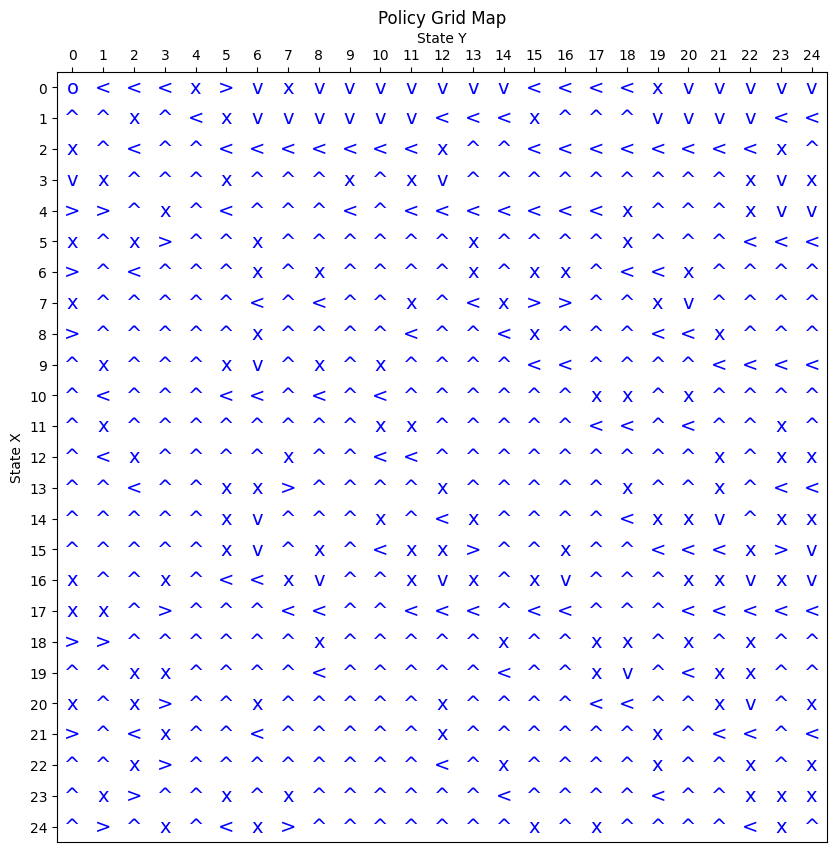

In [ ]:
if __name__ == "__main__":
  block_cells = [(random.choice(range(25)), random.choice(range(25))) for _ in range(50)]
  # block_cells = [(0,0)] #Check if sys.exit() works
  env = ReinforcementLearning(block_cells)
  optimal_function, optimal_policy = env.policy_iteration()

  print("Optimal value function for policy iteration")
  env.plot_function(optimal_function)

  print("Optimal policy function for policy iteration")
  env.plot_policy(optimal_policy)

  val_iter_function, val_iter_policy, iter = env.value_iteration()
  print("Optimal value function for value iteration")
  env.plot_function(val_iter_function)

  print("Optimal policy function for value_iteration")
  env.plot_policy(val_iter_policy)

4) Report

a) For data structure, I implement 2D-arrays from np.zeros and np.ones function of np to model the environment. The reason for this is simply because 2D-array are the simplest to implement and visualizing the environment as well as agent's range of actions.

Policy Performance

In [ ]:
import statistics

obstacle = [(random.choice(range(25)), random.choice(range(25))) for _ in range(50)]
policy_perf = ReinforcementLearning(obstacle)
start_state_list = []
median_of_steps = []

#Generate a start state
for i in range(3):
  start = (random.randint(0, 24), random.randint(0, 24))

  while start in obstacle or start == policy_perf.goal:
  #make sure the start state is not in obstacle
    start = (random.randint(0, 24), random.randint(0, 24))

  start_state_list.append(start)

#b) Random Policy Performance
print("\n b) Random Policy Performance")
#Create a random policy
policy = np.zeros((25, 25, 5))
for x in range(25):
  for y in range(25):
    action = random.choice(range(5))
    policy[x, y, action] = 1

#Uncommented to plot
# policy_perf.plot_policy(inter_policy)
median_of_steps.clear()
for start in start_state_list:
  random_steps = policy_perf.traversal(start, policy)
  if random_steps == 625:
    print(f"Loop encountered for random policy with start state at {start}")
  else:
    median_of_steps.append(random_steps)
    print(f"Random policy takes {random_steps} number of steps to reach the goal from {start}")
    median_of_steps.sort()
    median = statistics.median(median_of_steps)
    print("The median number of steps is: ", median)

#c) Intermediate Policy Performance
print("\n c) Intermediate Policy Performance")
inter_function, inter_policy = policy_perf.intermediate_policy_iteration(1)
#Uncommented to plot
# policy_perf.plot_policy(inter_policy)

median_of_steps.clear()
for start in start_state_list:
  inter_steps = policy_perf.traversal(start, inter_policy)
  if inter_steps == 625:
    print(f"Loop encountered for random policy with start state at {start}")
  else:
    print(f"Intermediate policy takes {inter_steps} number of steps to reach the goal from {start}")
    median_of_steps.append(inter_steps)

median_of_steps.sort()
median = statistics.median(median_of_steps)
print("The median number of steps is:", median)

#d) Optimal Policy Performance
print("\n d) Optimal Policy Performance")
optimal_function, optimal_policy = policy_perf.policy_iteration()
#Uncommented to plot
# policy_perf.plot_policy(optimal_policy)

median_of_steps.clear()
for start in start_state_list:
  optimal_steps = policy_perf.traversal(start, optimal_policy)
  if optimal_steps == 625:
    print(f"Loop encountered for random policy with start state at {start}")
  else:
    print(f"Optimal policy takes {optimal_steps} number of steps to reach the goal from {start}")
    median_of_steps.append(optimal_steps)

median_of_steps.sort()
median = statistics.median(median_of_steps)
print("The median number of steps is:", median)


 b) Random Policy Performance
Loop encountered for random policy with start state at (7, 2)
Loop encountered for random policy with start state at (9, 24)
Loop encountered for random policy with start state at (17, 18)

 c) Intermediate Policy Performance
Intermediate policy takes 9 number of steps to reach the goal from (7, 2)
Intermediate policy takes 33 number of steps to reach the goal from (9, 24)
Intermediate policy takes 35 number of steps to reach the goal from (17, 18)
The median number of steps is: 33

 d) Optimal Policy Performance
Optimal policy takes 9 number of steps to reach the goal from (7, 2)
Optimal policy takes 33 number of steps to reach the goal from (9, 24)
Optimal policy takes 35 number of steps to reach the goal from (17, 18)
The median number of steps is: 33


Analysis

b) Random Policy Performance
Since the policy is initialized randomly, I have not been able to record the number of steps the agent can take to reach the goal at any given start states. instead, I implement a max-step counter that signaling a loop encounter whenever my agent steps more than the amount of states possible (625 states). The result is as following:

Loop encountered for random policy with start state at (7, 2)

Loop encountered for random policy with start state at (9, 24)

Loop encountered for random policy with start state at (17, 18)

I think the reason is it's notoriously hard for the agent when there are a total of 5 actions to choose (so 1 in 5 chance of picking the right action toward the goal), in a 25x25 grid with around 50 obstacles. This is simply impossible for the agent to reach without luck or a clear guidance.

c) Intermediate Policy Performance

To measure the intermediate policy performance, I modified the policy_iteration method from terminating the loop after policy convergence has been reached to terminating the loop after the maximum number of iteration has been reached to get the policy before it converges, and set the max iteration to 1 to make sure the program terminate as soon as the The result is as following:

Intermediate policy takes 9 number of steps to reach the goal from (7, 2)

Intermediate policy takes 33 number of steps to reach the goal from (9, 24)

Intermediate policy takes 35 number of steps to reach the goal from (17, 18)

The median number of steps is: 33

This is the result for intermediate policy's performance. Even though it is not asked in the question, I have also generated a plot (commented) for the intermediate policy to make sure that it is not the same as an optimal policy despite having the same result.

d) Optimal Policy Performance

To measure the optimal policy performance, I generate the optimal policy from policy iteration. There should be no different on whether the policy is generated by policy iteration or value iteration, as they should all give the same optimal policy. I merely chose policy iteration because it is faster. The result is as following:

Intermediate policy takes 9 number of steps to reach the goal from (7, 2)

Intermediate policy takes 33 number of steps to reach the goal from (9, 24)

Intermediate policy takes 35 number of steps to reach the goal from (17, 18)

The median number of steps is: 33